# **Deep Learning Para el Reconocimiento de Numeración China**

Autores:

Julián Esteban García Duarte 2180025

Paula Andrea Castro Mendoza 2172011

Paula Catalina Hernández Ramírez

## Primera Parte: Preprocesamiento de Datos

Se obtiene acceso al drive, en donde estan guardadas las imagenes.

In [ ]:
from google.colab import drive

drive.mount('/Data')
folder_dir = '/Data/My Drive/IA/PROYECTO/data'


Mounted at /Data


**Se importan las librerias necesarias**

In [ ]:

import cv2
import numpy as np
import os
import csv
import pandas as pd
import keras
import seaborn as sns
import time
import pickle

import scipy.stats as stats
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Se cargan los datos de referencia (ground truth)

In [ ]:
# El directorio que contiene el archivo csv con el ground truth
ground_truth_dir = '/'.join([folder_dir, 'chinese_mnist.csv'])
# Se carga el archivo como un pandas dataframe
df = pd.read_csv(ground_truth_dir)
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


Se cuentan la cantidad de datos disponibles para cada clase. Se muestra que los datos están igualmente distribuidos y no es necesario hacer alteración alguna al dataset si en cuanto a distribución se trata.

In [ ]:
# Se extraen las clases y la cantidad de filas para cada clase
data = df.value.value_counts().sort_index()
print(data)

0            1000
1            1000
2            1000
3            1000
4            1000
5            1000
6            1000
7            1000
8            1000
9            1000
10           1000
100          1000
1000         1000
10000        1000
100000000    1000
Name: value, dtype: int64


**Funcion match_img:** Esta funcion carga una imagen y basada en el nombre de esta encuentra su correspondiente registro en el dataset de etiquetas.

In [ ]:
def match_img(img_path, img_name, dF):
# Carga una imagen y ubica su información en el dataFrame dado

  # Se carga la imagen
  img = cv2.imread('/'.join([img_path, img_name])) 

  # Se promedia el valor de el vector RGB, para obtener un unico valor
  # Se pasa de una matriz (64, 64, 3) a (64, 64)
  img_array = np.mean(img, axis=2)

  # Se aplana la imagen (convierte a un vector) y se normaliza
  img_array = img_array.flatten()/255

  img_rev = np.reshape(img_array, (64, 64))

  # Se extraen los identificadores de la imagen
  raw_name = img_name.split('.')[0]   # Se elimina la extensión de la imagen (".jpg")
  values = raw_name.split('_')        # Se separan sus identificadores
  
  # Los identificadores
  suite_id = int(values[1])
  sample_id = int(values[2])
  code = int(values[3])

  # Se extrae el registro asociado a esa imagen
  record = dF.loc[(dF['suite_id'] == suite_id) & (dF['sample_id'] == sample_id) & (dF['code']==code)]

  if len(record) != 1:
    record = None # Si hay mas de 1 valor encontrado o ninguno, la funcion retorna None
  else:
    record = record.values.tolist()[0]  # Se convierte el resultado a una lista
    record.extend(img_array)            # Se agrega la imagen aplanada como colummna individual
  
  return record


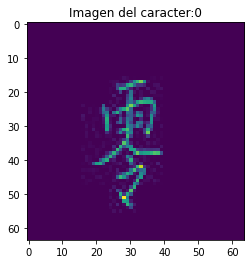

In [ ]:
vec1 = match_img('/Data/My Drive/IA/PROYECTO/data/1', 'input_1_1_1.jpg', df)

img1 = np.reshape(vec1[5:], (64, 64))

plt.imshow(img1)
plt.title("Imagen del caracter:{}".format(vec1[3]))
plt.show()

Se cargan las imagenes del dataset *chinese_mnist*, se convierten a vectores y se almacenan en un nuevo dataset con sus respectivas etiquetas.



In [ ]:
# Los nombres de las carpetas con las imagenes
folder_names = ['1', '2', '3']

# El directorio donde se guardan los datos
csv_d1 = '/'.join([folder_dir, 'chinese_features.csv'])

# Contador de imagenes cargadas
cont = 0

# Se abre el archivo csv
with open(csv_d1, 'w') as csv_file:
  # Objeto que sirve para escribir nuestro archivo csv
  writer = csv.writer(csv_file)
  
  # Se recorren las carpetas con las imagenes
  for data_dir in folder_names:
    # El directorio de la carpeta
    data_set_dir = '/'.join([folder_dir, data_dir])
    
    # Se recorren las imagenes del directorio 
    for img_name in os.listdir(data_set_dir): 
      # Se obtiene la imagen como vector asociada a su informacion
      row = match_img(data_set_dir, img_name, df)

      # Verifica si el procesamiento de la imagen fue exitoso
      if row != None:
        writer.writerow(row)
      else:
        print('Error, imagen no procesada: {}'.format(img_name))
        cont -= 1

      cont +=1

      if (cont % 450 == 0):
        print("{0:1.2f}%".format(cont/150))

print('Imagenes Cargadas {}'.format(cont))

3.00%
6.00%
9.00%
12.00%
15.00%
18.00%
21.00%
24.00%
27.00%
30.00%
33.00%
36.00%
39.00%
42.00%
45.00%
48.00%
51.00%
54.00%
57.00%
60.00%
63.00%
66.00%
69.00%
72.00%
75.00%
78.00%
81.00%
84.00%
87.00%
90.00%
93.00%
96.00%
99.00%
Imagenes Cargadas 15000


Se carga el data set ya listo para pasar a la fase de entrenamiento y testeo.

In [ ]:
gran_data_set = pd.read_csv('/'.join([folder_dir, './chinese_features.csv']), header=None)
gran_data_set.head()

,0,1,2,3,4,5,6,7,8,9,...,4091,4092,4093,4094,4095,4096,4097,4098,4099,4100
0,3,3,11,10,十,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,3,5,4,四,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,3,8,7,七,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,7,6,六,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,4,1,0,零,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se remueven las columnas no utiles para el proceso de entrenamiento

In [ ]:
n_cols = gran_data_set.shape[1]
idx_cols = [n for n in range(5, n_cols)] # Se generan los indices para las columnas de entrenamiento
idx_cols.insert(0, 3) # Se inserta el numero 3(Indice de la columna de ground truth) en la posición 0 de la lista 

depurado = gran_data_set.iloc[:, idx_cols]
# Se ajustan los indices
depurado.columns = np.arange(0, depurado.shape[1], 1)

# La dirección del archivo a guardar
final_dir =  '/'.join([folder_dir, 'chinese_final.csv'])

# Se guarda en el drive el dataframe como csv
with open(final_dir, 'w') as train_file:
  writer = csv.writer(train_file)
  writer.writerows(depurado.to_numpy())

#Se imprimen las primeras 5 filas
depurado.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Se modifican los valores de las etiquetas en el data set

Debido a que el dataset contiene (además de los digitos del 0 al 9) multiplos de 10 (10, 1000, etc), es necesario re-etiquetar estos valores para poder entrenar la red.

In [ ]:
# Se modifican los valores para los numeros mayores a 10 (1000, 100000, etc)
labels = np.sort(depurado.iloc[:, 0].unique())

# Se extrae la columna de las etiquetas
ground_truth = depurado.iloc[:, 0]

for idx, value in enumerate(labels):
  if value > 9:
    ground_truth[depurado.iloc[:, 0] == value] = idx

depurado.iloc[:, 0] = ground_truth
print(np.sort(depurado.iloc[:, 0].unique()))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Se divide el dataset entre entrenamiento y testeo

In [ ]:
from sklearn.model_selection import train_test_split

# Se sacan los datos de prueba y entrenamiento con una relacipon 80-20.
X_train, X_test, y_train, y_test = train_test_split(depurado.iloc[:, 1:], depurado.iloc[:, 0], test_size=0.2, random_state=21, shuffle=True)
# Se sacan los datos de prueba y entrenamiento con una relacipon 70-30.
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(depurado.iloc[:, 1:], depurado.iloc[:, 0], test_size=0.3, random_state=21, shuffle=True)
# Se sacan los datos de prueba y entrenamiento con una relacipon 90-10.
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(depurado.iloc[:, 1:], depurado.iloc[:, 0], test_size=0.1, random_state=21, shuffle=True)

Se muestra una tabla con los numeros y una imagen de prueba para cada digito

In [ ]:
gran_data_set = pd.read_csv('/'.join([folder_dir, './chinese_features.csv']), header=None)

# Se obtienen los numeros en caracteres occidentales
idxs_occ = np.sort(gran_data_set.iloc[:, 3].unique())
caracteres_oriental = []
imagenes = []

for idx in idxs_occ:
  idxs = gran_data_set.iloc[:, 3] == idx
  rows = gran_data_set[idxs]
  imagenes.append(rows.iloc[1, 5:])

  caracteres_oriental.append(rows.iloc[0, 4])

tabla_datos = pd.DataFrame({
    'NUMEROS_OCCIDENTAL': idxs_occ,
    'NUMEROS_ORIENTAL' : caracteres_oriental
})

tabla_datos.head(15)

,NUMEROS_OCCIDENTAL,NUMEROS_ORIENTAL
0,0,零
1,1,一
2,2,二
3,3,三
4,4,四
5,5,五
6,6,六
7,7,七
8,8,八
9,9,九


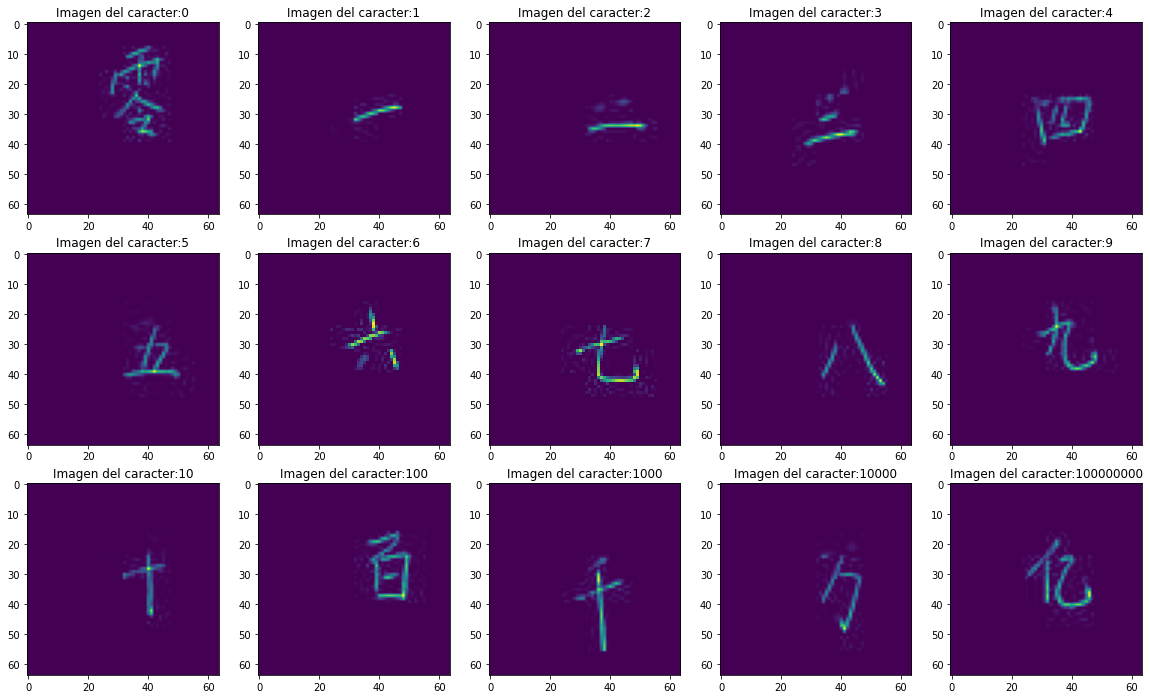

In [ ]:
plt.figure(figsize = (20,12))

for i_plot in range(0, 15):
  plt.subplot(3, 5, i_plot + 1)
  img_sub_plot = np.reshape(np.array(imagenes[i_plot], dtype=float), (64, 64))
  plt.imshow(img_sub_plot)
  plt.title("Imagen del caracter:{}".format(idxs_occ[i_plot]))

plt.show()

## **RANDOM FOREST & DECISION TREE**

La partición de los datos de trabajo permite generar el modelo a partir de los datos de entrenamiento para después comprobar su eficiencia con los datos reservados para test.

Los resultados de cualquier modelo basado en aprendizaje supervisado tienen una gran dependencia de los datos a partir de los cuales se han generado. Por ello, es fundamental cuidar su calidad y buscar siempre el equilibrio.

Es por eso que se toma variaciones de:

 - 70% del dataset para entrenar y un 30% para test.
 - 80% del dataset para entrenar y un 20% para test.
 - 90% del dataset para entrenar y un 10% para test.
 
Se entrena un estimador `RandomForestClassifier` con parámetros `max_depth`=5 y `random_state`=21

Se entrena un estimador `DecisionTreeClassifier` con parámetros `max_depth`=5 y `random_state`=21

Le sacamos un `accuracy_score` para la partición de test

# **Decision Tree classifier**

- Se tomo 80% del dataset para entrenar y un 20% para test.


In [ ]:
est = DecisionTreeClassifier(max_depth=5, random_state=21)
est.fit(X_train,y_train)
print(accuracy_score(est.predict(X_test), y_test))


0.22233333333333333


- Se tomo 70% del dataset para entrenar y un 30% para test.

In [ ]:
est = DecisionTreeClassifier(max_depth=5, random_state=21)
est.fit(X_train_70,y_train_70)
print(accuracy_score(est.predict(X_test_70), y_test_70))

0.20733333333333334


- Se tomo 90% del dataset para entrenar y un 10% para test.

In [ ]:
est = DecisionTreeClassifier(max_depth=5, random_state=21)
est.fit(X_train_90,y_train_90)
print(accuracy_score(est.predict(X_test_90), y_test_90))

0.21533333333333332


# **Random Forest Classifier**

- Se tomo 80% del dataset para entrenar y un 20% para test.

In [ ]:
est = RandomForestClassifier( max_depth=5, random_state=21)
est.fit(X_train,y_train)
a = accuracy_score(est.predict(X_test), y_test)
informe = classification_report(y_test, est.predict(X_test))
print(a)


0.3516666666666667


- Se tomo 70% del dataset para entrenar y un 30% para test.

In [ ]:
est = RandomForestClassifier( max_depth=5, random_state=21)
est.fit(X_train_70,y_train_70)
a = accuracy_score(est.predict(X_test_70), y_test_70)
informe = classification_report(y_test_70, est.predict(X_test_70))
print(a)
 

0.35533333333333333


- Se tomo 90% del dataset para entrenar y un 10% predecir


In [ ]:
est = RandomForestClassifier(max_depth=5, random_state=21)
est.fit(X_train_90,y_train_90)
a = accuracy_score(est.predict(X_test_90), y_test_90)
informe = classification_report(y_test_90, est.predict(X_test_90))
print(a)


0.3546666666666667


Se encoge la mejor configuración para el estimador `RandomForestClassifier` y para el estimador `DecisionTreeClassifier`.

- `RandomForestClassifier` con 70% del dataset para entrenar y un 30% para test.


- `DecisionTreeClassifier` con 80% del dataset para entrenar y un 20% predecir

Ahora variamos su `max_depth` entre 1-100 para evitar el “sobre-entrenado” o overfitting, a su vez que un  
"subajuste" o underfitting.

   Max_depth  Accuracy
0          1  0.100333
1         11  0.311000
2         21  0.333000
3         31  0.326667
4         41  0.329333
5         51  0.327000
6         61  0.327000
7         71  0.327000
8         81  0.327000
9         91  0.327000


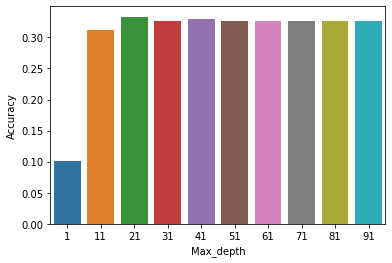

In [ ]:

list_accuracy = []
list_range = range(1,101,10)
for i in list_range: 
  est = DecisionTreeClassifier(max_depth=i, random_state=21)
  est.fit(X_train,y_train)
  a = accuracy_score(est.predict(X_test), y_test)
  list_accuracy.append(a)
  
df = pd.DataFrame(list(zip(list_range,list_accuracy)), columns = ['Max_depth','Accuracy'])
print(df)

sns.barplot(x = 'Max_depth',
            y = 'Accuracy',
            data = df)
plt.show()


   Max_depth  Accuracy
0          1  0.129111
1         11  0.535556
2         21  0.618444
3         31  0.620889
4         41  0.618889
5         51  0.611556
6         61  0.614000
7         71  0.614000
8         81  0.614000
9         91  0.614000


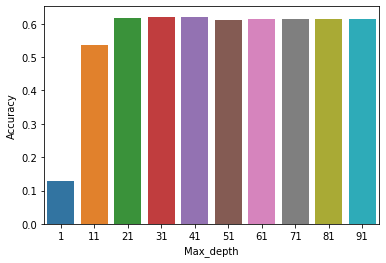

In [ ]:

list_accuracy = []
list_range = range(1,101,10)
for i in list_range: 
  est = RandomForestClassifier(max_depth=i, random_state=21)
  est.fit(X_train_70,y_train_70)
  a = accuracy_score(est.predict(X_test_70), y_test_70)
  list_accuracy.append(a)
  
df = pd.DataFrame(list(zip(list_range,list_accuracy)), columns = ['Max_depth','Accuracy'])
print(df)

sns.barplot(x = 'Max_depth',
            y = 'Accuracy',
            data = df)
plt.show()


Se encoge la mejor configuración de profundidad para el estimador `RandomForestClassifier` y para el estimador `DecisionTreeClassifier`.

- `RandomForestClassifier` con 80% del dataset para entrenar y un 20% para test. Con una profundiad de 51.

- `DecisionTreeClassifier` con 70% del dataset para entrenar y un 30% predecir. Con una profundidad de 41.


In [ ]:

est1 = DecisionTreeClassifier(max_depth=21, random_state=21) #guardar estimador

#medimos tiempo 
start1=datetime.now()
est1.fit(X_train,y_train)
time_80_DecisionTreeClasifier=datetime.now()-start1

DecisionTreeClassifier_80_acc = accuracy_score(est1.predict(X_test), y_test)
print("Accuracy DecisionTree",DecisionTreeClassifier_80_acc)
print ('Tiempo de ejecución: ', time_80_DecisionTreeClasifier  )

#------------------------------
est2 = RandomForestClassifier(max_depth= 41, random_state=21)

#tiempo

start=datetime.now()
est2.fit(X_train_70,y_train_70)
time_70_randomForestClassifier=datetime.now()-start

RandomForestClassifier_70_acc = accuracy_score(est2.predict(X_test_70), y_test_70)
print("Accuracy RandomForest ", RandomForestClassifier_70_acc)
print ('Tiempo de ejecución: ', time_70_randomForestClassifier  )



Accuracy DecisionTree 0.333
Tiempo de ejecución:  0:00:10.099657
Accuracy RandomForest  0.6188888888888889
Tiempo de ejecución:  0:00:18.260251


## **SUPPORT VECTOR MACHINE**

Implementamos SVM con el primer set de entrenamiento y testeo: **80% entrenamiento y 20% testeo**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datetime import datetime

est_80 = SVC(random_state=21)
#Timer
start=datetime.now()
est_80.fit(X_train, y_train)
time_80=datetime.now()-start
#Finaliza timer

y_pred_80=est_80.predict(X_test)

SVM_80_acc = accuracy_score(y_test, y_pred_80)
print('La precisión es de', SVM_80_acc)
print ('Tiempo de ejecución del entrenamiento: ',time_80)

La precisión es de 0.721
Tiempo de ejecución del entrenamiento:  0:08:02.948048


Implementamos SVM con el primer set de entrenamiento y testeo: **70% entrenamiento y 30% testeo**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datetime import datetime

est_70 = SVC(random_state=21)
#Timer
start=datetime.now()
est_70.fit(X_train_70, y_train_70)
time_70=datetime.now()-start
#Finaliza Timer

y_pred_70=est_70.predict(X_test_70)

SVM_70_acc = accuracy_score(y_test_70, y_pred_70)
print('La precisión es de', SVM_70_acc)
print ('Tiempo de ejecución del entrenamiento: ',time_70)

La precisión es de 0.7108888888888889
Tiempo de ejecución del entrenamiento:  0:07:41.305375


Implementamos SVM con el primer set de entrenamiento y testeo: **90% entrenamiento y 10% testeo**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datetime import datetime

est_90 = SVC(random_state=21)
#Timer
start=datetime.now()
est_90.fit(X_train_90, y_train_90)
time_90=datetime.now()-start
#Finaliza Timer

y_pred_90=est_90.predict(X_test_90)

SVM_90_acc = accuracy_score(y_test_90, y_pred_90)
print('La precisión es de', SVM_90_acc)
print ('Tiempo de ejecución del entrenamiento: ',time_90)

La precisión es de 0.7466666666666667
Tiempo de ejecución del entrenamiento:  0:09:48.779231


## **REDES NEURONALES**

Para estas pruebas se usó la misma configuración de la red vista en el punto anterior.

•  Capas: 5

•  Funcion de activación para capas ocultas: Relu

•  Función de Activación para la capa de salida: Softmax

•  Tipo de capas: Dense



In [ ]:
# Se crea una para los modelos de prueba

def crear_modelo():
  model = keras.Sequential([
      keras.layers.Dense(512, activation='relu', input_dim=64*64),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'THE_NET'
  )

  model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  #model.summary()
  return model

##Porque se usuaron las funciones de activación seleccionadas: 

Una función de activación devuelve una salida que será generada por la neurona dada una entrada o conjunto de entradas. Cada una de las capas que conforman la red neuronal tienen una función de activación que permitirá reconstruir o predecir.

**Función** **Relu**:

Cuando procesamos una imagen, cada capa de convolución debe capturar algún patrón en la imagen y pasarla en la siguiente capa de convolución. Los valores negativos no son importantes en el procesamiento de imágenes y, por lo tanto, se establecen en 0. Pero los valores positivos después de la convolución deben pasar a la siguiente capa. Es por eso que Relu se utilizo como una función de activación. Si utilizamos sigmoide o tanh, la información se pierde ya que ambas funciones modificarán las entradas a un rango muy cerrado.

**Función** **Softmax**:

Se utiliza cuando queremos tener una representación en forma de probabilidades.
Se utiliza para para normalizar tipo multiclase, aparte de un buen rendimiento en las últimas capas.







Se ejecuta cada modelo para una cantidad distinta de porciones de entrenamiento. 70, 80 y 90

In [ ]:
import time
import pickle

train_size_portions = {'70':{'X_train': X_train_70, 'X_test': X_test_70, 'y_train': y_train_70, 'y_test': y_test_70},
                       '80': {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test},
                       '90': {'X_train': X_train_90, 'X_test': X_test_90, 'y_train': y_train_90, 'y_test': y_test_90}
}

folder_bin = '/Data/My Drive/IA/PROYECTO/bin'

tiempos = {}
records = {}

models = []

for idx, portion in enumerate(train_size_portions.keys()):
  # Se crea el modelo 
  model = crear_modelo()

  # Se obtienen las porciones de entrenamiento y testeo para la distribución de la iteracion (70-30, 80-20, 90-10)
  sliced = train_size_portions[portion]

  # Se mide el tiempo para el momento antes de entrenar
  start = time.time()

  # Se entrena al modelo con los datos proporcionados
  records[portion] = model.fit(sliced['X_train'], sliced['y_train'], 
                      epochs=25, 
                      validation_data=(sliced['X_test'], sliced['y_test']),
                      verbose=0)

  # Se mide el tiempo para el momento despues de entrenar
  end = time.time()

  # Se registra el tiempo de ejecución 
  tiempos[portion]=end-start

  # Se guarda el modelo en el drive
  with open('/'.join([folder_bin, 'model_{}.pkl'.format(portion)]), 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://9fd3fc6d-2a2c-4f7c-86b7-de7cefcfee58/assets
INFO:tensorflow:Assets written to: ram://6e23ad79-bf5c-4e9d-bf01-cc9546f28087/assets
INFO:tensorflow:Assets written to: ram://cfdf195b-2b4c-4b7f-aca4-74a596cc6b96/assets


Se grafican los resultados

Text(0.5, 0, 'Porcentajes de entrenamiento con 25 Epochs')

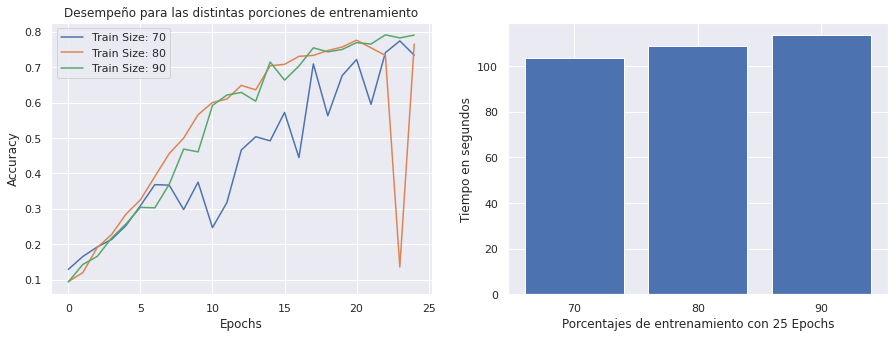

In [ ]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for rec in records.keys():
  # Se grafica el desempeño de la red
  plt.plot(records[rec].history['val_accuracy'], label='Train Size: {}'.format(rec))

plt.title('Desempeño para las distintas porciones de entrenamiento')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(tiempos.keys(), tiempos.values())
plt.ylabel('Tiempo en segundos')
plt.xlabel('Porcentajes de entrenamiento con 25 Epochs')
#plt.ylim(100,150)
#aumentar 100-140 ylim


## **Comparación de Algoritmos**
• Tiempos de ejecución del entrenamiento.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


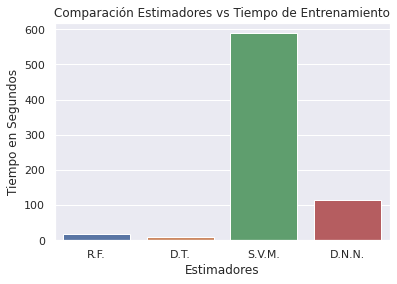

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

x = ['R.F.', 'D.T.', 'S.V.M.', 'D.N.N.']
y1 = [time_70_randomForestClassifier.total_seconds(), time_80_DecisionTreeClasifier.total_seconds(), time_90.total_seconds(), tiempos['90']]

sns.barplot(x, y1)
plt.xlabel('Estimadores')
plt.ylabel('Tiempo en Segundos')
plt.title('Comparación Estimadores vs Tiempo de Entrenamiento')
plt.show()


• Comparación de Métricas (accuracy)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


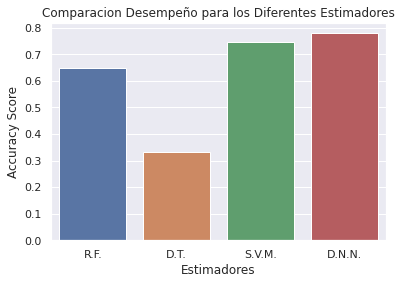

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

x = ['R.F.', 'D.T.', 'S.V.M.', 'D.N.N.']
y2 = [RandomForestClassifier_90_acc, DecisionTreeClassifier_80_acc, SVM_90_acc, records['90'].history['val_accuracy'][-1]]

sns.barplot(x, y2)
plt.xlabel('Estimadores')
plt.ylabel('Accuracy Score')
plt.title('Comparacion Desempeño para los Diferentes Estimadores')
plt.show()


• Comparación de Métricas  (Accuracy vs. Tiempo)

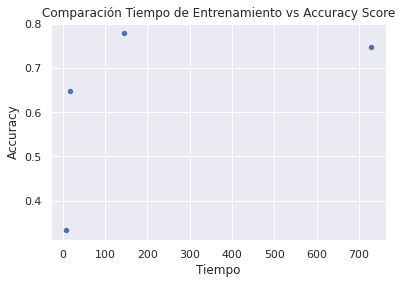

In [ ]:
data_Frame_todo = pd.DataFrame({
    'Clasificadores': x,
    'Tiempo' : y1,
    'Accuracy' : y2 })

sns.scatterplot(data=data_Frame_todo, x='Tiempo', y='Accuracy')
plt.title('Comparación Tiempo de Entrenamiento vs Accuracy Score')
plt.show()


In [ ]:
data_Frame_todo.head()

,Clasificadores,Tiempo,Accuracy
0,R.F.,18.525080,0.646667
1,D.T.,8.853756,0.333000
2,S.V.M.,727.260846,0.746667
3,D.N.N.,143.940950,0.779333


•**Conclusión**: se escogió una DNN porque es el método de clasificación cuya combinación de parámetros más eficaz resulta en una mejor relación accuracy-tiempo que los primeros métodos usados.

# Modificación de Parametros para la Red Neuronal

Para estas pruebas se usó la misma configuración de la red vista en el punto anterior.


•  Capas: 5

•  Funcion de activación para capas ocultas: Relu

•  Función de Activación para la capa de salida: Softmax

•  Tipo de capas: Dense

## Variacion del Learning Rate

Para observar como afecta el learning rate en la red neuronal se tomaron 10 valores desde 0.001 (bajo) hasta 0.1 (alto). 



In [ ]:
def learning_rate_var(rates, verbose):
  from keras import backend as K
  records = {}
  tiempos = {}

  for rate in rates.tolist():
    # Se crea el modelo 
    model = crear_modelo(verbose=False)

    # Se obtiene la porcion de entrenamiento
    data = train_size_portions['90']

    # Se mide el tiempo para el momento antes de entrenar
    start = time.time()

    # Se establece el learning rate deseado
    K.set_value(model.optimizer.learning_rate, rate)

    # Se entrena al modelo con los datos proporcionados
    records[str(rate)] = model.fit(data['X_train'], data['y_train'], 
                        epochs=25, 
                        validation_data=(data['X_test'], data['y_test']),
                        verbose=verbose)

    # Se mide el tiempo para el momento despues de entrenar
    end = time.time()

    # Se registra el tiempo de ejecución 
    tiempos[str(rate)]=end-start

  return records, tiempos

records_learning_rate, tiempos_learning_rate = learning_rate_var(np.round(np.linspace(0.001, 0.1, 10), 3), verbose=0)

[0.001 0.012 0.023 0.034 0.045 0.056 0.067 0.078 0.089 0.1  ]


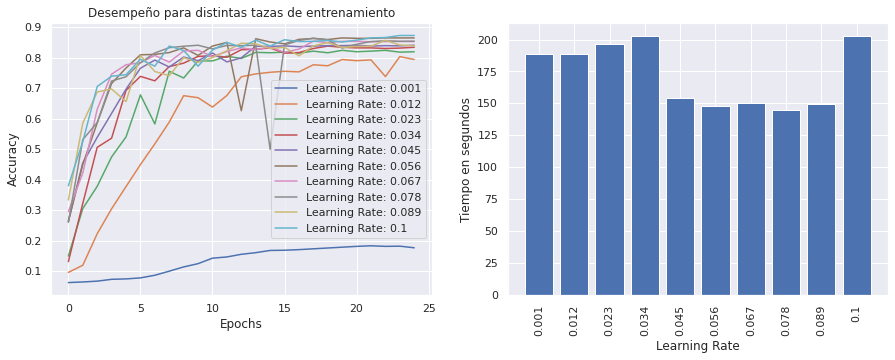

In [ ]:
plot_results(records_learning_rate, tiempos_learning_rate, "Desempeño para distintas tazas de entrenamiento", "Learning Rate")

## Variación de Optimizadores

Se evaluaron los siguientes optimizadores:



*   SDG
*   RMSprop
* Adam
* Adadelta
* Adagrad
* Adamax
* Nadam
* Ftrl



In [ ]:
def optimizer_var(optimizers, verbose=0):
  from keras import backend as K
  records = {}
  tiempos = {}

  for opt in optimizers:
    # Se crea el modelo 
    model = crear_modelo(optimizer=opt, verbose=False)

    # Se obtiene la porcion de entrenamiento
    data = train_size_portions['90']

    # Se mide el tiempo para el momento antes de entrenar
    start = time.time()

    # Se entrena al modelo con los datos proporcionados
    records[opt] = model.fit(data['X_train'], data['y_train'], 
                        epochs=25, 
                        validation_data=(data['X_test'], data['y_test']),
                        verbose=verbose)

    # Se mide el tiempo para el momento despues de entrenar
    end = time.time()

    # Se registra el tiempo de ejecución 
    tiempos[opt]=end-start

  return records, tiempos

# Optimizadores
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
records_opt, tiempos_opt = optimizer_var(optimizers=optimizers, verbose=0)

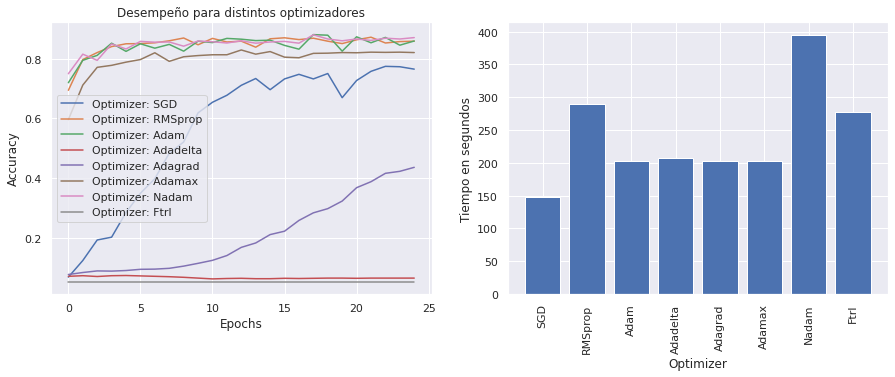

In [ ]:
plot_results(records_opt, tiempos_opt, "Desempeño para distintos optimizadores", "Optimizer")

## Dummy Variables (One Hot Encoding)

Se probó el desempeño de la red con y sin esta configuración para las etiquetas.

In [ ]:
def onhe_test(verbose=0):
  # Se obtiene la porcion de entrenamiento
  data = train_size_portions['90']

  # Se separan las etiquetas en dummy variables usando el metodo de one hot
  y_train_ohe = tf.keras.utils.to_categorical(data['y_train'], num_classes=15)
  y_test_ohe = tf.keras.utils.to_categorical(data['y_test'], num_classes=15)

  records = {}
  tiempos = {}

  ############################### MODELO CON ONE HOT ENCODING #############

  # Se crea el modelo para ONE HOT ENCODING
  model = crear_modelo(optimizer='sgd', verbose=False, one_hot=True)

  # Se mide el tiempo para el momento antes de entrenar
  start = time.time()

  # Se entrena al modelo con los datos proporcionados
  records['ohe'] = model.fit(data['X_train'], y_train_ohe, 
                      epochs=25, 
                      validation_data=(data['X_test'], y_test_ohe),
                      verbose=verbose)
  
  # Se mide el tiempo para el momento despues de entrenar
  end = time.time()

  # Se registra el tiempo de ejecución 
  tiempos['ohe']=end-start

  ##################################### MODELO SI ONE HOT ENCODING ##########

  # Se crea el modelo SIN ONE HOT ENCODING
  model = crear_modelo(optimizer='sgd', verbose=False, one_hot=False)

  # Se mide el tiempo para el momento antes de entrenar
  start = time.time()

  # Se entrena al modelo con los datos proporcionados
  records['No-ohe'] = model.fit(data['X_train'], data['y_train'], 
                      epochs=25, 
                      validation_data=(data['X_test'], data['y_test']),
                      verbose=verbose)

  # Se mide el tiempo para el momento despues de entrenar
  end = time.time()

  # Se registra el tiempo de ejecución 
  tiempos['No-ohe']=end-start
  return records, tiempos

records_ohe, tiempos_ohe = onhe_test()

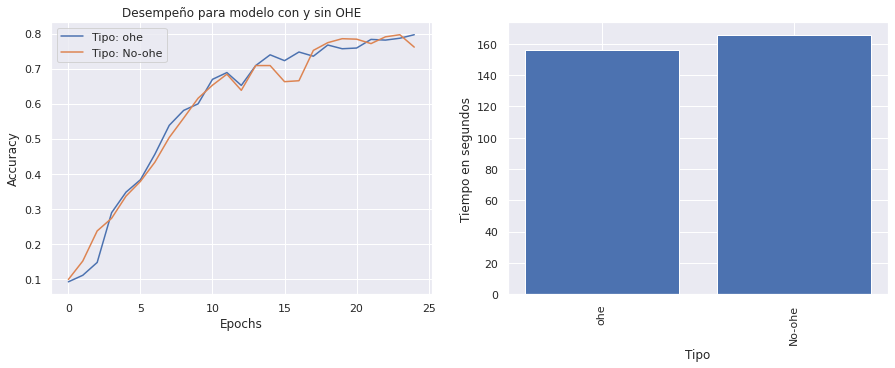

In [ ]:
plot_results(records_ohe, tiempos_ohe, "Desempeño para modelo con y sin OHE", "Tipo")

## Arquitectura de la Red

In [ ]:
def arquitectura_var(verbose = 0):
  modelos_arc = {}
  records = {}
  tiempos = {}

  modelos_arc['Plano'] = keras.Sequential([
      keras.layers.Dense(512, activation='relu', input_dim=64*64),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['Plano'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Modelo con una configuracion ascendente
  modelos_arc['Ascendente'] = keras.Sequential([
      keras.layers.Dense(32, activation='relu', input_dim=64*64),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['Ascendente'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


  modelos_arc['Descendente'] = keras.Sequential([
      keras.layers.Dense(512, activation='relu', input_dim=64*64),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['Descendente'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


  modelos_arc['Mixto'] = keras.Sequential([
      keras.layers.Dense(128, activation='relu', input_dim=64*64),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['Mixto'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  for tipo_modelo in modelos_arc:
    model = modelos_arc[tipo_modelo]
    # Se obtiene la porcion de entrenamiento
    data = train_size_portions['90']

    # Se mide el tiempo para el momento antes de entrenar
    start = time.time()

    # Se entrena al modelo con los datos proporcionados
    records[tipo_modelo] = model.fit(data['X_train'], data['y_train'], 
                        epochs=25, 
                        validation_data=(data['X_test'], data['y_test']),
                        verbose=verbose)

    # Se mide el tiempo para el momento despues de entrenar
    end = time.time()

    # Se registra el tiempo de ejecución 
    tiempos[tipo_modelo]=end-start
  
  return records, tiempos
  
records_arc, tiempos_arc = arquitectura_var(verbose=0)

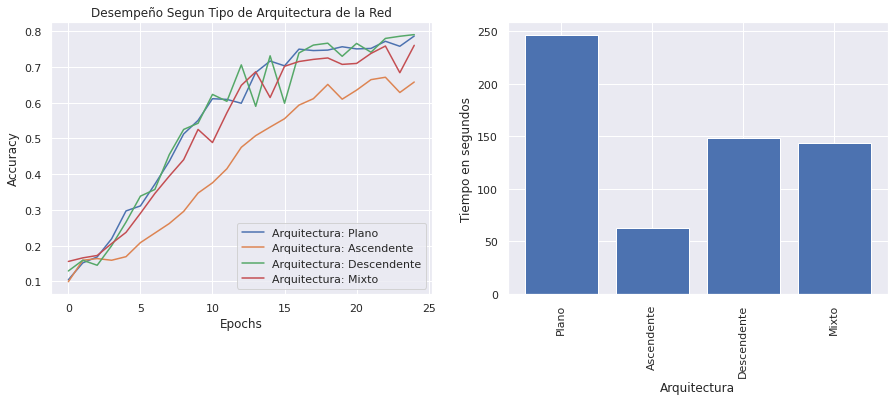

In [ ]:
plot_results(records_arc, tiempos_arc, "Desempeño Segun Tipo de Arquitectura de la Red", "Arquitectura")

## Cantidad de neuronas

In [ ]:
def arquitectura_var(verbose = 0):
  modelos_arc = {}
  records = {}
  tiempos = {}

  # Modelo con 512 neuronas
  modelos_arc['512'] = keras.Sequential([
      keras.layers.Dense(512, activation='relu', input_dim=64*64),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['512'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Modelo con 256 neuronas
  modelos_arc['256'] = keras.Sequential([
      keras.layers.Dense(256, activation='relu', input_dim=64*64),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['256'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Modelo con 128 neuronas
  modelos_arc['128'] = keras.Sequential([
      keras.layers.Dense(128, activation='relu', input_dim=64*64),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['128'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Modelo con 64 neuronas
  modelos_arc['64'] = keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_dim=64*64),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
  modelos_arc['64'].compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  for tipo_modelo in modelos_arc:
    model = modelos_arc[tipo_modelo]
    # Se obtiene la porcion de entrenamiento
    data = train_size_portions['90']

    # Se mide el tiempo para el momento antes de entrenar
    start = time.time()

    # Se entrena al modelo con los datos proporcionados
    records[tipo_modelo] = model.fit(data['X_train'], data['y_train'], 
                        epochs=25, 
                        validation_data=(data['X_test'], data['y_test']),
                        verbose=verbose)

    # Se mide el tiempo para el momento despues de entrenar
    end = time.time()

    # Se registra el tiempo de ejecución 
    tiempos[tipo_modelo]=end-start
  
  return records, tiempos
records_neuronas, tiempos_neuronas = arquitectura_var(verbose=0)

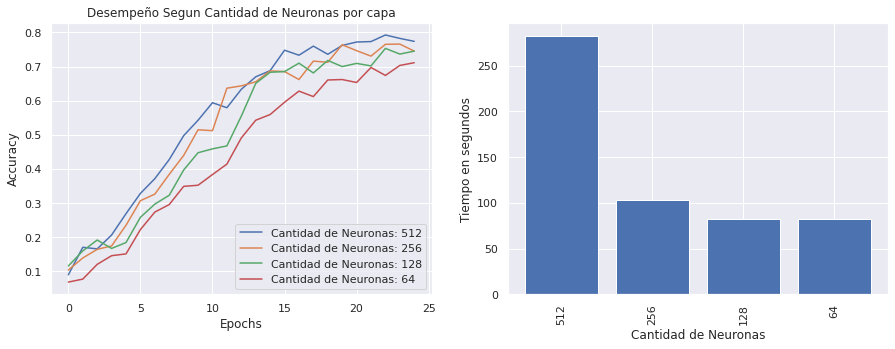

In [ ]:
plot_results(records_neuronas, tiempos_neuronas, "Desempeño Segun Cantidad de Neuronas por capa", "Cantidad de Neuronas")

## Cantidad de Capas

In [ ]:
def learning_rate_var(n_capas, verbose):
  from keras.layers import Dense
  records = {}
  tiempos = {}

  for cant in n_capas:
    # Se crea el modelo 
    model = keras.Sequential()
    model.add(Dense(input_dim=64*64, units=512, activation='relu'))

    # Se agregan las capas
    for _ in range(cant - 1):
      model.add(Dense(units=512, activation='relu'))

    # Capa de salida
    model.add(Dense(units=15, activation='softmax'))

    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Se obtiene la porcion de entrenamiento
    data = train_size_portions['90']

    # Se mide el tiempo para el momento antes de entrenar
    start = time.time()

    # Se entrena al modelo con los datos proporcionados
    records[str(cant)] = model.fit(data['X_train'], data['y_train'], 
                        epochs=25, 
                        validation_data=(data['X_test'], data['y_test']),
                        verbose=verbose)

    # Se mide el tiempo para el momento despues de entrenar
    end = time.time()

    # Se registra el tiempo de ejecución 
    tiempos[str(cant)]=end-start

  return records, tiempos

records_unidades, tiempos_unidades = learning_rate_var(range(3, 15, 2), verbose=0)

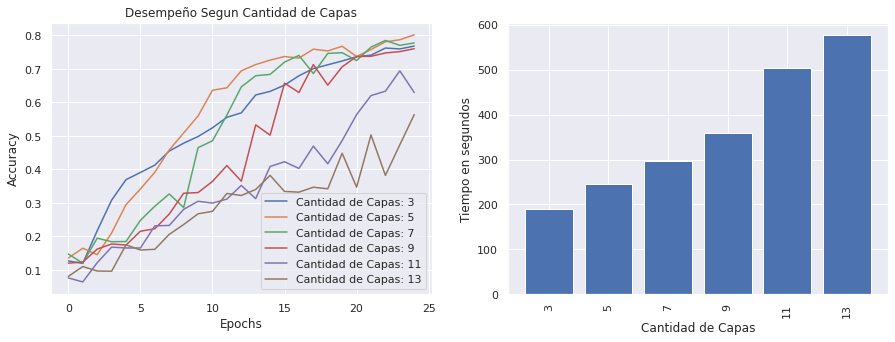

In [ ]:
plot_results(records_unidades, tiempos_unidades, "Desempeño Segun Cantidad de Capas", "Cantidad de Capas")

## Se construye el modelo final

In [ ]:
from keras import backend as K
    
modelo_final = keras.Sequential([
      keras.layers.Dense(512, activation='relu', input_dim=64*64),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(15, activation='softmax'),
      ],
      name = 'SkyNet'
  )
modelo_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#K.set_value(modelo_final.optimizer.learning_rate, 0.87)

# Se obtiene la porcion de entrenamiento
data = train_size_portions['90']

# Se separan las etiquetas en dummy variables usando el metodo de one hot
y_train_ohe = tf.keras.utils.to_categorical(data['y_train'], num_classes=15)
y_test_ohe = tf.keras.utils.to_categorical(data['y_test'], num_classes=15)


# Se mide el tiempo para el momento antes de entrenar
start = time.time()

# Se entrena al modelo con los datos proporcionados
records_final = modelo_final.fit(data['X_train'], y_train_ohe, 
                    epochs=24, 
                    validation_data=(data['X_test'], y_test_ohe),
                    verbose=1)

# Se mide el tiempo para el momento despues de entrenar
end = time.time()

# Se registra el tiempo de ejecución 
tiempos_final=end-start

plt.plot(records_final.history['val_accuracy'])